# Multilayer Perceptron (MLP) model

This is the code to run the best trained MLP model on the test set.

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

import pickle
import time

## Preparing test dataset

In [2]:
# Importing preprocessed test set data
test_dataset = pd.read_csv('test_dataset.csv') 

# Split the test data into features (X_test) and target variable (y_test)
X_test = test_dataset.iloc[:, :-1]  
y_test = test_dataset.iloc[:, -1] 

In [3]:
# Preprocessing test set data before feeding to MLP model

# Binary encoding of labels
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

# Convert to 2D PyTorch tensors
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test= torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## Loading pre-trained model

In [4]:
# Define the structure of MLP model before importing pre-trained version. 
class MLP_layers(nn.Module):
    # initialising attributes of MLP model
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_size, activation, weight_init):
        super(MLP_layers, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation = activation
        self.weight_init = weight_init
        
        # Define input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Define hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Define output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # defines foward pass of MLP model. 
        # Flatten input tensor to match input size. 
        x = x.view(-1, self.input_size)
        
        # Forward pass through input layer
        x = self.activation(self.input_layer(x))
        
        # Forward pass through hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        
        # Forward pass through output layer with sigmoid activation
        x = torch.sigmoid(self.output_layer(x))
        return x

In [5]:
# Load the model from a file

import pickle
with open('best_mlp.pkl', 'rb') as file:
    
    best_model_mlp = pickle.load(file)

## Testing on test set

In [6]:
# Record start time
start_time = time.time()

# Make predictions on test data
y_pred_mlp = best_model_mlp.predict(X_test)

# Record end time
end_time = time.time()

# Compute testing time
testing_time = end_time - start_time
print("Testing Time:", testing_time, "seconds")

Testing Time: 0.17850112915039062 seconds


## Evaluating the model

In [7]:
# Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)

print("Accuracy:", accuracy_mlp)
print("Precision:", precision_mlp)
print("Recall:", recall_mlp)
print("F1 Score:", f1_mlp)
print("ROC AUC Score:", roc_auc_mlp)

Accuracy: 0.9549969202340622
Precision: 0.9643154294166589
Recall: 0.9301765650080257
F1 Score: 0.9469384049748081
ROC AUC Score: 0.9520141733047173


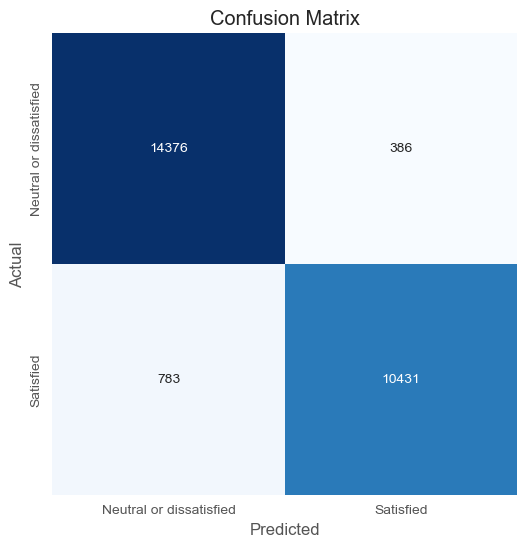

In [8]:
# Calculate confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_mlp, cmap='Blues', annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Adjust the tick labels
plt.xticks(ticks=[0.5, 1.5], labels=['Neutral or dissatisfied', 'Satisfied'])
plt.yticks(ticks=[0.5, 1.5], labels=['Neutral or dissatisfied', 'Satisfied'])

plt.show()


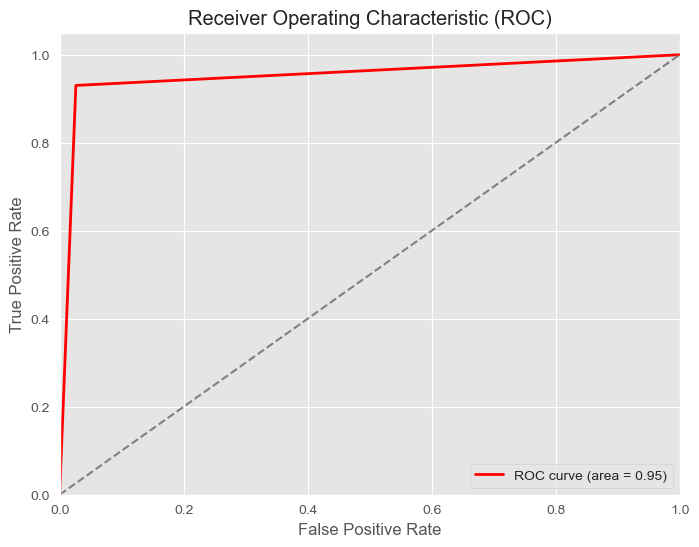

In [9]:
# Calculate ROC curve and AUC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp)
roc_auc_mlp= auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()